In [1]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import stats
from IPython import display
%matplotlib inline
sys.path.append("../..")
from diachr import BaitAnalysis

# Create directory for output files generated in this notebook 
NOTEBOOK_RESULTS_DIR = 'results/bait_analysis'
os.makedirs(NOTEBOOK_RESULTS_DIR, exist_ok=True)

# Bait analysis

[Based on imbalances in the relative orientations of mapped paired-end reads at baited fragments, we calculated a score and, based on these scores, assigned each baited fragment to one of the classes BFC0, BFC1, and BFC2.](baited_fragment_classification.ipynb) In this notebook, we investigate the correlation between the classification into these three classes and the baits actually used for the underlying CHi-C experiment. In order to keep the layout of the notebook clear, we outsourced some parts of the analysis to a separate module.

In [2]:
bait_analysis = BaitAnalysis()

## Input files

We use the bait coordinates from a publication by [Mifsud et al. (2015)](https://pubmed.ncbi.nlm.nih.gov/25938943/) and the baited fragment coordinates from a publication by [Javierre et al. (2016)](https://pubmed.ncbi.nlm.nih.gov/27863249/). The selection criteria for baits given in the two publications are identical and the publication by Javierre et al. (2016) refers to the publication by Mifsud et al. (2015) in this regard. We therefore assume that the same baits were used in both cases. In our documentation on Read The Docs we describe how we prepared these files for this analysis (file format conversion and LiftOver from `hg19` to `hg38`). In addition, we use three BED files with fragments of classes BFC0, BFC1 and BFC2, which we previously created in the [notebook for baited fragment classification](baited_fragment_classification.ipynb) based on the corresponding interaction data. Finally, we use the `hg38` reference sequence to analyze the GC content of baits. Note that a corresponding index (`.fai`) must exist in addition to the FASTA file. Reference genomes can be downloaded and indexed here: [Get_started.ipynb](../Get_started.ipynb)

In [3]:
# Select author and cell type for which this analysis should be performed
AUTHOR = 'MIF' # JAV, SCH, MIF
PROTOCOL = 'CHC' # HC or CHC
CELL_TYPE_SHORT = 'GM12878' # MK, ERY, NEU, MON, MAC_M0, ..., MESC, MFLC, MESC_R1ABKO, GM12878
OUT_PREFIX = AUTHOR + '_' + CELL_TYPE_SHORT + '_' + PROTOCOL +'_REPC'

# Previously created files with BFC0, BFC1, and BFC2 fragments
BFC0_BED_FILE = 'results/baited_fragment_classification' + '/bfc_lists/' + AUTHOR + '/' + OUT_PREFIX  + '_bfc0.bed'
BFC1_BED_FILE = 'results/baited_fragment_classification' + '/bfc_lists/' + AUTHOR + '/' + OUT_PREFIX  + '_bfc1.bed'
BFC2_BED_FILE = 'results/baited_fragment_classification' + '/bfc_lists/' + AUTHOR + '/' + OUT_PREFIX  + '_bfc2.bed'

if AUTHOR == 'JAV' or AUTHOR == 'MIF':
    
    # BED file with bait coordinates
    BAIT_BED_FILE = '../../additional_files/mifsud_2015/mifsud_baits_hg38.bed'
    #BAIT_BED_FILE = '../../additional_files/mifsud_2015/mifsud_baits_hg19.bed'
    
    # BED file with baited fragment coordinates
    BAITED_FRAGMENT_BED_FILE = '../../additional_files/javierre_2016/javierre_baited_digests_hg38.bed'
    #BAITED_FRAGMENT_BED_FILE = '../../additional_files/javierre_2016/javierre_baited_digests_hg19.bed'
    
    # Genome sequence file for GC content analysis
    # A corresponding index file 'genome.fa.fai' must be in the same directory
    GENOME_FILE = '../../additional_files/reference_sequence/hg38_genome.fa'
    
elif AUTHOR == 'SCH':
    
    # BED file with bait coordinates
    BAIT_BED_FILE = '../../additional_files/schoenefelder_2015/schoenefelder_baits_mm10.bed'
    
    # BED file with baited fragment coordinates
    BAITED_FRAGMENT_BED_FILE = '../../additional_files/schoenefelder_2015/schoenefelder_baited_digests_mm10.bed'
    
    # Genome sequence file for GC content analysis
    GENOME_FILE = '../../additional_files/reference_sequence/mm10_genome.fa'

## Assign baits and BF classes to baited fragments

The central data structure in this analysis is a dictionary from which, given the coordinates of a baited fragment, the coordinates of the associated baits and the BF class can be retrieved. The following function creates such a data structure from the given input files.

In [4]:
FRAGMENTS_WITH_BAITS_DICT = bait_analysis.init_fragments_with_baits_dict(
    bait_bed_file = BAIT_BED_FILE,
    baited_fragment_bed_file = BAITED_FRAGMENT_BED_FILE,
    bfc0_bed_file = BFC0_BED_FILE,
    bfc1_bed_file = BFC1_BED_FILE,
    bfc2_bed_file = BFC2_BED_FILE,
    verbose=True)

[INFO] Init 'FRAGS_WITH_BAITS_dict' ...
	[INFO] Assign baits to their fragments ...
		[INFO] Total number of baits: 37,602
		[INFO] Assigned baits: 37,572
		[INFO] Unassigned baits: 30
		[INFO] Total number of baited fragments: 22,056
		[INFO] Number of fragments with at least one bait: 22,055
		[INFO] Number of fragments without bait: 1
			[INFO] Fragments without bait:
				chr22_KI270879v1_alt	275558	284927
	[INFO] Assign fragments to their BF classes and baits to 5' or 3' ends ...
		[INFO] BFC0: 6,572 (29.80%)
		[INFO] BFC1: 6,535 (29.63%)
		[INFO] BFC2: 7,436 (33.72%)
		[INFO] BFCX: 1,512 (6.86%)
		[INFO] Total number of baited fragments: 22,055
		[INFO] Number of BFC0, BFC1, and BFC2 fragments: 20,543
	[INFO] Remove BFCX fragments from dictionary ...
	[INFO] Determine numbers of baited fragments with 1, 2 or more baits ...
		[INFO] 1 baits: 5,361 (26.10%)
		[INFO] 2 baits: 15,182 (73.90%)
		[INFO] 2< baits: 0 (0.00%)
		[INFO] Total number of baited fragments: 20,543
[INFO] ... don

For the bait and baited fragment coordinates of Mifsud (2015) and Javierre (2016), out of a total of 37,602 baits, 30 baits could not be assigned to any fragment. Furthermore, out of a total of 22,056 baited fragments, one fragment was not assigned a bait. These cases are due to the LiftOver from `hg19` to `hg38`. If the same assignment is performed with hg19 coordinates, then all baits are assigned and each baited fragment is assigned at least one bait. To verify this, the hg38 coordinates can be swapped out for the hg19 coordinates in the 'Input data' section of this notebook.

Fragments of class BFCX are not associated with any classifiable interactions. Because the classification of baited fragments is based on interaction data, such fragments cannot be assigned to class BFC0, BFC1, or BFC2. BFCX fragments typically make up only a small proportion of all baited fragments and are included here for completeness. We exclude BFCX fragments from all subsequent analyses.

Some bait design tools can assign more than two baits to a baited fragment, which should be taken into account in the analysis. Therefore, the number of baited fragments assigned more than two baits is also reported.


### Usage of the data structure

Here are the first five items to illustrate the data structure:

In [5]:
print(list(FRAGMENTS_WITH_BAITS_DICT.items())[:5])

[('chr1\t896515\t912788', {'B5_COORDS': [], 'B3_COORDS': ['chr1\t912476\t912596'], 'BFC': 2}), ('chr1\t912789\t915238', {'B5_COORDS': ['chr1\t912789\t912909'], 'B3_COORDS': ['chr1\t915001\t915121'], 'BFC': 2}), ('chr1\t915239\t938701', {'B5_COORDS': ['chr1\t915239\t915359'], 'B3_COORDS': ['chr1\t938577\t938697'], 'BFC': 1}), ('chr1\t954044\t968260', {'B5_COORDS': ['chr1\t954103\t954223'], 'B3_COORDS': ['chr1\t968140\t968260'], 'BFC': 1}), ('chr1\t968261\t992014', {'B5_COORDS': ['chr1\t968261\t968381'], 'B3_COORDS': ['chr1\t991894\t992014'], 'BFC': 0})]


Information about a given baited fragment can be retrieved using the fragment coordinates:

In [6]:
if AUTHOR == 'JAV' or AUTHOR == 'MIF':
    print('5\' bait coordinates: ' + str(FRAGMENTS_WITH_BAITS_DICT['chr1\t896515\t912788']['B5_COORDS']))
    print('3\' bait coordinates: ' + str(FRAGMENTS_WITH_BAITS_DICT['chr1\t896515\t912788']['B3_COORDS']))
    print('BF class: ' + str(FRAGMENTS_WITH_BAITS_DICT['chr1\t896515\t912788']['BFC']))
if AUTHOR == 'SCH':
    print('5\' bait coordinates: ' + str(FRAGMENTS_WITH_BAITS_DICT['chr1\t3100832\t3102475']['B5_COORDS']))
    print('3\' bait coordinates: ' + str(FRAGMENTS_WITH_BAITS_DICT['chr1\t3100832\t3102475']['B3_COORDS']))
    print('BF class: ' + str(FRAGMENTS_WITH_BAITS_DICT['chr1\t3100832\t3102475']['BFC']))

5' bait coordinates: []
3' bait coordinates: ['chr1\t912476\t912596']
BF class: 2


## Split fragments with baits data structure hierarchically according to bait characteristics

Up to this point, we distinguished baited fragments based on their BF classes. Next, we additionally distinguish them based on their bait characteristics. We divide the baited fragments into three categories:

1. Unilaterally baited fragments with a bait only on either the 5' or 3' end
2. Bilaterally baited fragments with at least one shifted bait
3. Bilaterally baited fragments without shifted baits

A bait is considered shifted if the distance between the bait and the restriction site is more than `max_dist` bases. A baited fragment is considered shifted if it has at least one shifted bait. Based on these characteristics, we divide the data structure introduced above into three parts:

In [7]:
MAX_DIST = 0
UNILATERAL_DICT, BIILATERAL_SHIFTED_DICT, BIILATERAL_UNSHIFTED_DICT, SPLIT_CNT_DICT = \
    bait_analysis.split_frags_with_baits_dict_by_bait_characteristics(FRAGMENTS_WITH_BAITS_DICT, max_dist=MAX_DIST)

In addition to the three fragment-with-baits dictionaries, the function returns a dictionary with baited fragment counts for the different BF classes and bait characteristics.

In [8]:
df_split_cnt = pd.DataFrame(data=SPLIT_CNT_DICT)
df_split_cnt
#bait_analysis.get_latex_table_a(split_cnt_dict=SPLIT_CNT_DICT)

,BFC0,BFC1,BFC2
UNILATERAL,56,2599,2758
BILATERAL_SHIFTED,3982,2988,3224
BILATERAL_UNSHIFTED,2534,948,1454


In the following analyses, we will analyze baited fragments in terms of bait characteristics and BF classes.

## Unilaterally baited fragments

### Unilaterally vs. bilaterally baited fragments

First, we investigated whether there is a dependency between unilateral baiting of target fragments and the classification into the three BF classes. For this purpose, we performed a Fisher's exact test in which we compared the ratio of unilaterally to bilaterally baited fragments within BFC0 to that within BFC1 and BFC2.

In [9]:
df_cont = df_split_cnt.drop(columns=['BFC1', 'BFC2'])
df_cont['BFC12'] = df_split_cnt['BFC1'] + df_split_cnt['BFC2']
df_cont.loc['BILATERAL'] = df_cont.loc['BILATERAL_SHIFTED'] + df_cont.loc['BILATERAL_UNSHIFTED']
df_cont.drop(labels=['BILATERAL_SHIFTED', 'BILATERAL_UNSHIFTED'], axis=0, inplace=True)
df_cont.loc['Total'] = df_cont.sum(numeric_only=True,axis=0)
df_cont['Total'] = df_cont.sum(numeric_only=True,axis=1)
df_cont
#bait_analysis.get_latex_table_b(split_cnt_dict=SPLIT_CNT_DICT)

,BFC0,BFC12,Total
UNILATERAL,56,5357,5413
BILATERAL,6516,8614,15130
Total,6572,13971,20543


In [10]:
contingency_table = [
    [df_cont['BFC0']['UNILATERAL'], df_cont['BFC12']['UNILATERAL']],
    [df_cont['BFC0']['BILATERAL'], df_cont['BFC12']['BILATERAL']]]

odds_ratio, p_value = stats.fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

Prior odds ratio: 0.013819431337894813
P-value: 0.0


### Unilaterally baited fragments separated into 5' and 3' baited fragments

Next, we investigated whether there is a dependency between the end at which fragments are baited and the classification into the three BF classes. For this purpose, we determined the numbers of 5' and 3' end baited fragments for BFC0, BFC1 and BFC2.

**Count fragments:**

In [11]:
BAITED_5_3_CNT_DICT = {
    'BFC0': {'5_BAITED': 0, '3_BAITED': 0},
    'BFC1': {'5_BAITED': 0, '3_BAITED': 0},    
    'BFC2': {'5_BAITED': 0, '3_BAITED': 0}
}
for f_key in UNILATERAL_DICT.keys():
    
    # Get BF class
    bfc = UNILATERAL_DICT[f_key]['BFC']
       
    # Count fragments with baits at the 5' or 3' end
    if len(UNILATERAL_DICT[f_key]['B5_COORDS'])==0:     
        BAITED_5_3_CNT_DICT['BFC' + str(bfc)]['3_BAITED'] += 1
    elif len(UNILATERAL_DICT[f_key]['B3_COORDS'])==0:
        BAITED_5_3_CNT_DICT['BFC' + str(bfc)]['5_BAITED'] += 1
    else:
        print('[EROOR] Fragment is not unilaterally baited!')

**Report counts:**

In [12]:
df = pd.DataFrame(data=BAITED_5_3_CNT_DICT)
df.index = ['5\' baited', '3\' baited']
df.loc['Total'] = df.sum(numeric_only=True,axis=0)
df.loc[:,'Total'] = df.sum(numeric_only=True,axis=1)
df.T
#bait_analysis.get_latex_table_c(baited_5_3_cnt_dict=BAITED_5_3_CNT_DICT)

,5' baited,3' baited,Total
BFC0,32,24,56
BFC1,2594,5,2599
BFC2,5,2753,2758
Total,2631,2782,5413


**Perform Fisher's exact test for BFC1 and BFC2:**

In [13]:
contingency_table = [
    [BAITED_5_3_CNT_DICT['BFC1']['5_BAITED'], BAITED_5_3_CNT_DICT['BFC1']['3_BAITED']],
    [BAITED_5_3_CNT_DICT['BFC2']['5_BAITED'], BAITED_5_3_CNT_DICT['BFC2']['3_BAITED']]]

odds_ratio, p_value = stats.fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

Prior odds ratio: 285651.28
P-value: 0.0


## Bilaterally baited fragments with shifted baits

For BFC1, we find many examples where the 5' end bait is right next to the restriction site (as it should be) and the 3' end bait is shifted towards the center of the fragment (which is accepted, if a bait cannot be placed better).

BDC1 example: chr2:208,144,486-208,147,056


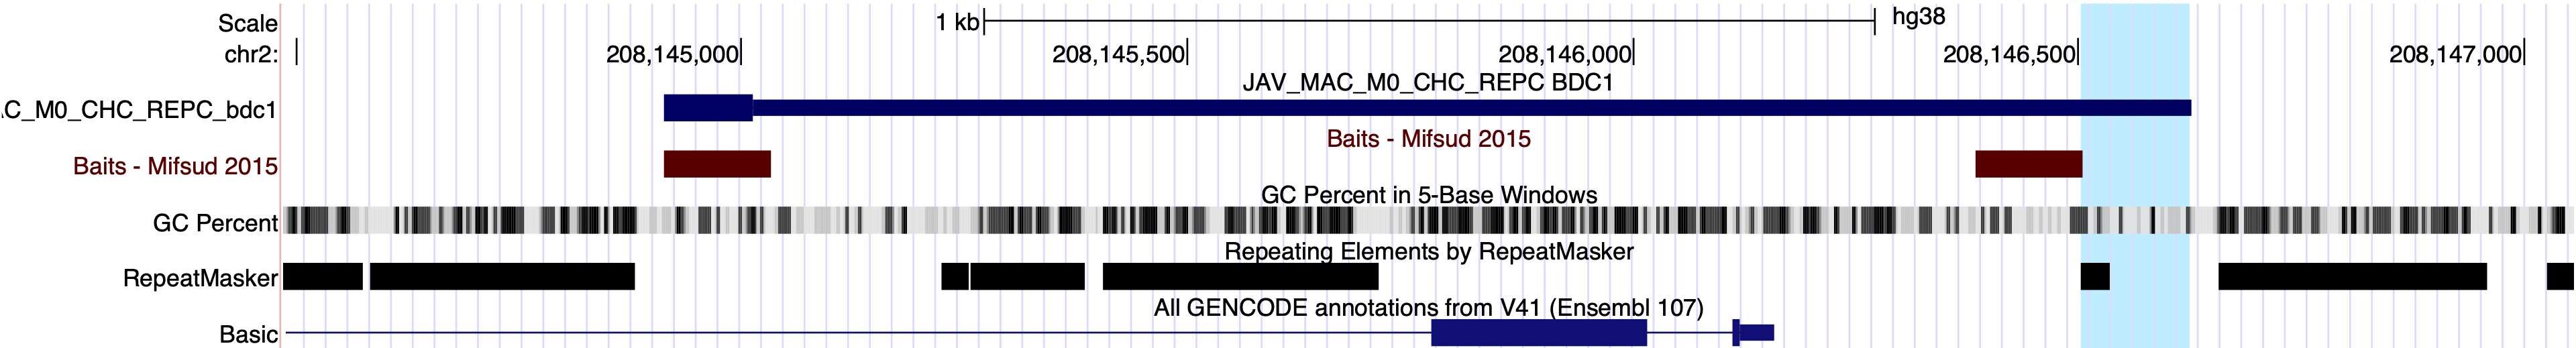

In [14]:
print("BDC1 example: chr2:208,144,486-208,147,056")
display.Image("../../docs/img/bdc1_shifted_bait_ucsc_example.png")

For BFC2, the opposite is true. Here we find many examples where the 5' bait is shifted while the 3' bait is right next to the restriction site.

BDC2 example: chr2:102,179,857-102,182,542


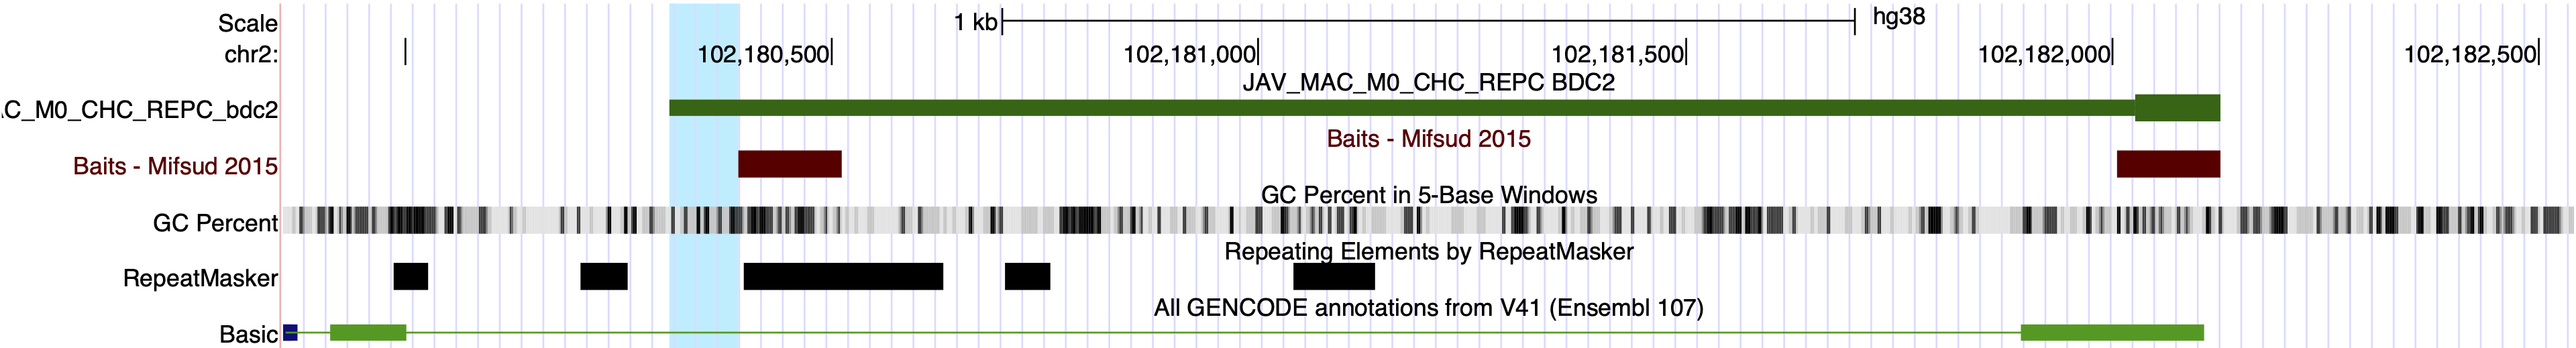

In [15]:
print("BDC2 example: chr2:102,179,857-102,182,542")
display.Image("../../docs/img/bdc2_shifted_bait_ucsc_example.png")

### Comparison of bilaterally baited fragments with and without shifted baits

We investigated whether there is a dependency between shifted baits and the classification into the three BF classes. For this purpose, we performed a Fisher's exact test in which we compared the ratio of bilaterally baited fragments with and without shifted baits within BFC0 to that within BFC1 and BFC2.

In [16]:
df = pd.DataFrame(data=SPLIT_CNT_DICT)
df['BFC12'] = df['BFC1'] + df['BFC2']
df.drop("BFC1", axis=1, inplace=True)
df.drop("BFC2", axis=1, inplace=True)
df.drop("UNILATERAL", axis=0, inplace=True)
df.loc[:,'Total'] = df.sum(numeric_only=True,axis=1)
df.loc['Total'] = df.sum(numeric_only=True,axis=0)
df
#bait_analysis.get_latex_table_d(split_cnt_dict=SPLIT_CNT_DICT)

,BFC0,BFC12,Total
BILATERAL_SHIFTED,3982,6212,10194
BILATERAL_UNSHIFTED,2534,2402,4936
Total,6516,8614,15130


In [17]:
contingency_table = [
    [df['BFC0']['BILATERAL_SHIFTED'], df['BFC12']['BILATERAL_SHIFTED']],
    [df['BFC0']['BILATERAL_UNSHIFTED'], df['BFC12']['BILATERAL_UNSHIFTED']]]

odds_ratio, p_value = stats.fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

Prior odds ratio: 0.6076257933952718
P-value: 3.885204435448978e-46


### Distributions of distances between baits and their restriction sites

Next, we determined the distributions of the distances between 5' and 3' baits and their restriction sites. For this purpose, we defined a function that is passed a fragment-with-baits dictionary of bilaterally baited fragments and returns two equally long lists of distances, one for the 5' end and another for the 3' end. We call the function separately for each BF class, so we get a total of six lists of distances.

In [18]:
BFC0_B5_DIST_LIST, BFC0_B3_DIST_LIST = bait_analysis.get_lists_of_bait_restriction_site_distances(
    bilateral_shifted_dict=BIILATERAL_SHIFTED_DICT,
    bf_classes=[0])

BFC1_B5_DIST_LIST, BFC1_B3_DIST_LIST = bait_analysis.get_lists_of_bait_restriction_site_distances(
    bilateral_shifted_dict=BIILATERAL_SHIFTED_DICT,
    bf_classes=[1])

BFC2_B5_DIST_LIST, BFC2_B3_DIST_LIST = bait_analysis.get_lists_of_bait_restriction_site_distances(
    bilateral_shifted_dict=BIILATERAL_SHIFTED_DICT,
    bf_classes=[2])

In addition, we defined a function that creates boxplots for the distributions of the distances for the 5' and 3' ends as well as for the three BF classes.

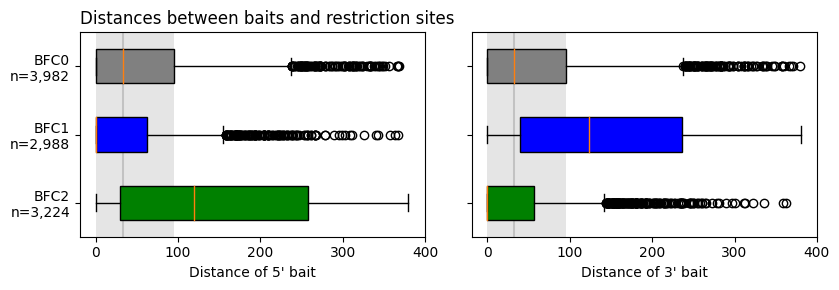

In [19]:
bait_analysis.create_bfc_boxplot(
    bfc0_b5=BFC0_B5_DIST_LIST,
    bfc0_b3=BFC0_B3_DIST_LIST,
    bfc1_b5=BFC1_B5_DIST_LIST,
    bfc1_b3=BFC1_B3_DIST_LIST,
    bfc2_b5=BFC2_B5_DIST_LIST,
    bfc2_b3=BFC2_B3_DIST_LIST,
    title='Distances between baits and restriction sites',
    xlabel_l='Distance of 5\' bait',
    xlabel_r='Distance of 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_distances_between_baits_and_restriction_sites.pdf')

**Explanation of the plot:** The boxplots for the distances of the 5' baits are shown on the left and those of the 3' baits on the right. The top boxplots (gray) show the distributions of distances for BFC0 fragments. The range between the first and third quantile is highlighted in lightgray. Below the boxplots for BFC0, the boxplots for BFC1 (blue) and BFC2 (green) are shown.

The boxplots above show the distributions of 5’ and 3’ baits independently. But in fact we have a pair of distances for each fragment. We determine the differences in distances for each pair, separately for the three BF classes.

In [20]:
# Get lists with differences in the distances of 5' and 3' baits
BFC0_DIFF_DIST_LIST = [x[0]-x[1] for x in zip(BFC0_B5_DIST_LIST, BFC0_B3_DIST_LIST)]
BFC1_DIFF_DIST_LIST = [x[0]-x[1] for x in zip(BFC1_B5_DIST_LIST, BFC1_B3_DIST_LIST)]
BFC2_DIFF_DIST_LIST = [x[0]-x[1] for x in zip(BFC2_B5_DIST_LIST, BFC2_B3_DIST_LIST)]

We reuse our plot function to create box plots for the differences in distances of 5' and 3' baits. Note that in this case the boxplots on the left and right are identical.

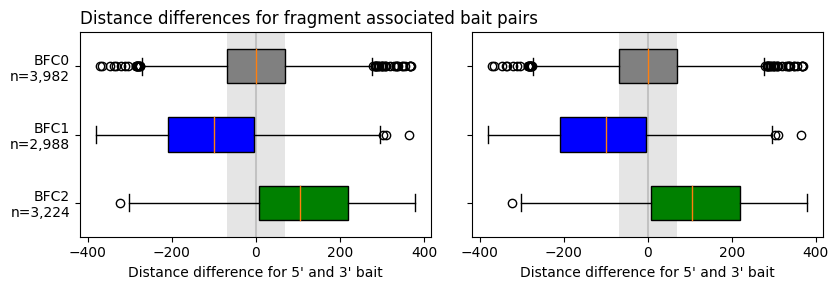

In [21]:
bait_analysis.create_bfc_boxplot(
    bfc0_b5=BFC0_DIFF_DIST_LIST,
    bfc0_b3=BFC0_DIFF_DIST_LIST,
    bfc1_b5=BFC1_DIFF_DIST_LIST,
    bfc1_b3=BFC1_DIFF_DIST_LIST,
    bfc2_b5=BFC2_DIFF_DIST_LIST,
    bfc2_b3=BFC2_DIFF_DIST_LIST,
    title='Distance differences for fragment associated bait pairs',
    xlabel_l='Distance difference for 5\' and 3\' bait',
    xlabel_r='Distance difference for 5\' and 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_distance_differences_for_fragment_associated_bait_pairs.pdf')

To assess the deviations of the differences from zero for statistical significance, we use a Wilcoxon signed rank test.

In [22]:
print(stats.wilcoxon(BFC0_DIFF_DIST_LIST))
print(stats.wilcoxon(BFC1_DIFF_DIST_LIST))
print(stats.wilcoxon(BFC2_DIFF_DIST_LIST))

WilcoxonResult(statistic=3916123.5, pvalue=0.5901550024078536)
WilcoxonResult(statistic=593855.0, pvalue=3.5637052825545024e-264)
WilcoxonResult(statistic=687062.5, pvalue=1.3244446679962532e-286)


## Bilaterally baited fragments without shifted baits

For the baited fragments with unshifted baits at both ends, we examined the GC and repeat content of baits. For this purpose, we create a dictionary from which the sequences of baits can be retrieved via their coordinates.

In [23]:
bait_analysis.init_bait_seq_dict(genome_fasta_file=GENOME_FILE,
                                 bait_bed_file=BAIT_BED_FILE,
                                 working_directory=NOTEBOOK_RESULTS_DIR)

### GC content

In addition, we defined a function that returns the GC content of a given DNA sequence.

In [24]:
bait_analysis.get_gc_content_seq('NtacgCGCGC')

0.7

Analogous to the analysis with the distances between baits and restriction sites, we defined a function that is passed a fragments-with-baits dictionary containing bilaterally baited fragments and returns two lists of equal length with the GC content of the 5' and 3' baits. Again, we apply this function separately for the three BF classes, giving us a total of six lists.

In [25]:
BFC0_B5_GC_LIST, BFC0_B3_GC_LIST = bait_analysis.get_lists_of_bait_gc_content(
    BIILATERAL_UNSHIFTED_DICT,
    bf_classes=[0])

BFC1_B5_GC_LIST, BFC1_B3_GC_LIST = bait_analysis.get_lists_of_bait_gc_content(
    BIILATERAL_UNSHIFTED_DICT,
    bf_classes=[1])

BFC2_B5_GC_LIST, BFC2_B3_GC_LIST = bait_analysis.get_lists_of_bait_gc_content(
    BIILATERAL_UNSHIFTED_DICT,
    bf_classes=[2])

Then we reuse our boxplot function to compare the distributions of GC contents.

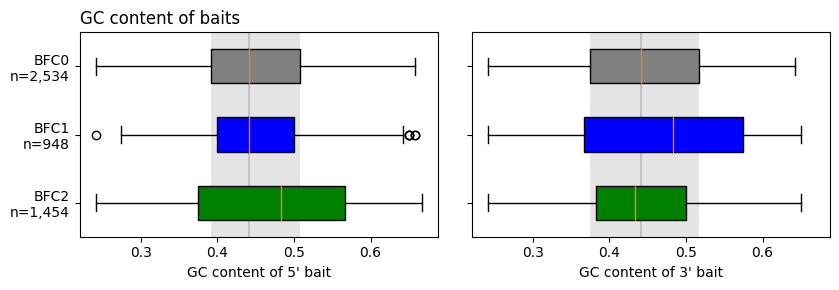

In [26]:
bait_analysis.create_bfc_boxplot(
    bfc0_b5=BFC0_B5_GC_LIST,
    bfc0_b3=BFC0_B3_GC_LIST,
    bfc1_b5=BFC1_B5_GC_LIST,
    bfc1_b3=BFC1_B3_GC_LIST,
    bfc2_b5=BFC2_B5_GC_LIST,
    bfc2_b3=BFC2_B3_GC_LIST,
    title='GC content of baits',
    xlabel_l='GC content of 5\' bait',
    xlabel_r='GC content of 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_baits.pdf')

We again determine the differences in the GC contents of baits associated with the same fragment.

In [27]:
BFC0_DIFF_GC_LIST = [x[0]-x[1] for x in zip(BFC0_B5_GC_LIST, BFC0_B3_GC_LIST)]
BFC1_DIFF_GC_LIST = [x[0]-x[1] for x in zip(BFC1_B5_GC_LIST, BFC1_B3_GC_LIST)]
BFC2_DIFF_GC_LIST = [x[0]-x[1] for x in zip(BFC2_B5_GC_LIST, BFC2_B3_GC_LIST)]

We reuse our boxplot function to visualize the distributions of differences. Remember that in this case the boxplots on the left and right are identical.

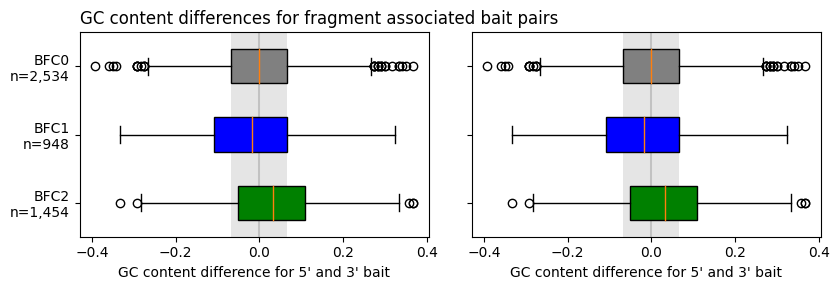

In [28]:
bait_analysis.create_bfc_boxplot(
    bfc0_b5=BFC0_DIFF_GC_LIST,
    bfc0_b3=BFC0_DIFF_GC_LIST,
    bfc1_b5=BFC1_DIFF_GC_LIST,
    bfc1_b3=BFC1_DIFF_GC_LIST,
    bfc2_b5=BFC2_DIFF_GC_LIST,
    bfc2_b3=BFC2_DIFF_GC_LIST,
    title='GC content differences for fragment associated bait pairs',
    xlabel_l='GC content difference for 5\' and 3\' bait',
    xlabel_r='GC content difference for 5\' and 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_differences_of_fragment_associated_bait_pairs.pdf')

To assess the deviations of the differences from zero for statistical significance, we use a Wilcoxon signed rank test.

In [29]:
print(stats.wilcoxon(BFC0_DIFF_GC_LIST))
print(stats.wilcoxon(BFC1_DIFF_GC_LIST))
print(stats.wilcoxon(BFC2_DIFF_GC_LIST))

WilcoxonResult(statistic=1450996.5, pvalue=0.10119984164807655)
WilcoxonResult(statistic=175928.0, pvalue=8.448663878403663e-06)
WilcoxonResult(statistic=361852.5, pvalue=1.4849904901226015e-19)


### Repeat content

We also performed an analogous analysis for the repeat content of baits. We assess the repeat content of baits based on soft-masked repeats (lowercase letters) in the reference sequence.

In [30]:
bait_analysis.get_repeat_content_seq('NtacgCGCGC')

0.4

Get lists containing the repeat content of baits.

In [31]:
BFC0_B5_REPEAT_LIST, BFC0_B3_REPEAT_LIST = bait_analysis.get_lists_of_bait_repeat_content(
    BIILATERAL_UNSHIFTED_DICT,
    bf_classes=[0])

BFC1_B5_REPEAT_LIST, BFC1_B3_REPEAT_LIST = bait_analysis.get_lists_of_bait_repeat_content(
    BIILATERAL_UNSHIFTED_DICT,
    bf_classes=[1])

BFC2_B5_REPEAT_LIST, BFC2_B3_REPEAT_LIST = bait_analysis.get_lists_of_bait_repeat_content(
    BIILATERAL_UNSHIFTED_DICT,
    bf_classes=[2])

Show the distributions of repeat content in boxplots.

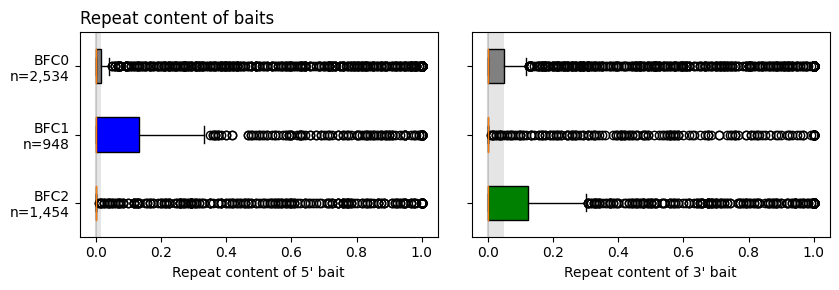

In [32]:
bait_analysis.create_bfc_boxplot(
    bfc0_b5=BFC0_B5_REPEAT_LIST,
    bfc0_b3=BFC0_B3_REPEAT_LIST,
    bfc1_b5=BFC1_B5_REPEAT_LIST,
    bfc1_b3=BFC1_B3_REPEAT_LIST,
    bfc2_b5=BFC2_B5_REPEAT_LIST,
    bfc2_b3=BFC2_B3_REPEAT_LIST,
    title='Repeat content of baits',
    xlabel_l='Repeat content of 5\' bait',
    xlabel_r='Repeat content of 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_of_baits.pdf')

Determine the differences for baits associated with the same fragment.

In [33]:
BFC0_DIFF_REPEAT_LIST = [x[0]-x[1] for x in zip(BFC0_B5_REPEAT_LIST, BFC0_B3_REPEAT_LIST)]
BFC1_DIFF_REPEAT_LIST = [x[0]-x[1] for x in zip(BFC1_B5_REPEAT_LIST, BFC1_B3_REPEAT_LIST)]
BFC2_DIFF_REPEAT_LIST = [x[0]-x[1] for x in zip(BFC2_B5_REPEAT_LIST, BFC2_B3_REPEAT_LIST)]

Show the distributions of the differences in boxplots.

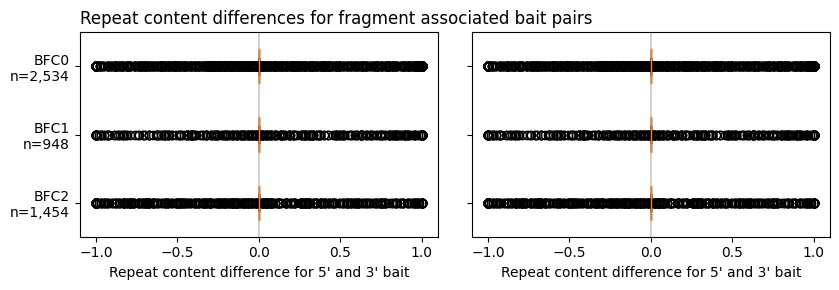

In [34]:
bait_analysis.create_bfc_boxplot(
    bfc0_b5=BFC0_DIFF_REPEAT_LIST,
    bfc0_b3=BFC0_DIFF_REPEAT_LIST,
    bfc1_b5=BFC1_DIFF_REPEAT_LIST,
    bfc1_b3=BFC1_DIFF_REPEAT_LIST,
    bfc2_b5=BFC2_DIFF_REPEAT_LIST,
    bfc2_b3=BFC2_DIFF_REPEAT_LIST,
    title='Repeat content differences for fragment associated bait pairs',
    xlabel_l='Repeat content difference for 5\' and 3\' bait',
    xlabel_r='Repeat content difference for 5\' and 3\' bait',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_differences_of_fragment_associated_bait_pairs.pdf')

Test the differences for deviations from zero for statistical significance.

In [35]:
print(stats.wilcoxon(BFC0_DIFF_REPEAT_LIST))
print(stats.wilcoxon(BFC1_DIFF_REPEAT_LIST))
print(stats.wilcoxon(BFC2_DIFF_REPEAT_LIST))

WilcoxonResult(statistic=299668.5, pvalue=0.9723901816264399)
WilcoxonResult(statistic=34235.5, pvalue=0.00044561489726602547)
WilcoxonResult(statistic=74207.0, pvalue=4.220354260646035e-06)
